In [1]:
#imoport the kaggle.json file that collected from kaggle website

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"siamnsu","key":"ee82e59520ae026cedaa857850165591"}'}

In [2]:
#Providing Id passwoed from aforementioned cell

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"siamnsu","key":"ee82e59520ae026cedaa857850165591"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

print('complete')

complete


In [3]:
!kaggle datasets download -d siamnsu/data-set-upscalled

Dataset URL: https://www.kaggle.com/datasets/siamnsu/data-set-upscalled
License(s): unknown
 98% 169M/173M [00:04<00:00, 46.4MB/s]
100% 173M/173M [00:04<00:00, 42.3MB/s]


In [4]:
#Extracting Zip files
from zipfile import ZipFile
file_name = '/content/data-set-upscalled.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('complete')

complete


In [5]:
pip install Augmentor

In [6]:
import Augmentor

In [7]:
p = Augmentor.Pipeline("/content/Upscaled cropped Plat ptf a11", output_directory= "/content/Output")

Initialised with 336 image(s) found.
Output directory set to /content/Output.

In [8]:
p.rotate(probability =0.7, max_left_rotation= 10, max_right_rotation=10)

In [9]:
p.zoom(probability=0.3, min_factor= 1.1, max_factor=1.6)

In [10]:
p.flip_left_right(probability=0.5)

p.flip_top_bottom(probability=0.5)

p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)

p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)

p.random_color(probability=0.5, min_factor=0.5, max_factor=1.5)

p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

p.random_erasing(probability=0.5, rectangle_area=0.2)
p.invert(probability=0.5)  # Invert colors with a probability of 0.5





In [11]:
p.sample(2200)

Processing <PIL.Image.Image image mode=RGB size=2562x2097 at 0x78355E617430>: 100%|██████████| 2200/2200 [19:24<00:00,  1.89 Samples/s]


In [12]:
import pathlib
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Directory containing images
data_dir = pathlib.Path('/content/Output')
img_height = 416
img_width = 416

# Function to preprocess images
def preprocess_image(image):
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.grayscale_to_rgb(image)
    return image

# Convert all images to RGB
def convert_images_to_rgb(data_dir):
    # Ensure the output directory exists
    output_dir = data_dir / 'processed'
    output_dir.mkdir(parents=True, exist_ok=True)

    for image_path in data_dir.glob('*.*'):
        if image_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
            # Load image
            img = tf.io.read_file(str(image_path))
            img = tf.image.decode_image(img, channels=1)  # Ensure grayscale loading
            img = preprocess_image(img)

            # Convert Tensor to NumPy array
            img = img.numpy()

            # Convert NumPy array to PIL Image
            img_pil = Image.fromarray(np.uint8(img * 255))

            # Save the processed image
            output_path = output_dir / image_path.name
            img_pil.save(output_path)

# Run the conversion
convert_images_to_rgb(data_dir)


In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size =(img_height, img_width),
    batch_size=32)


Found 2200 files belonging to 5 classes.
Using 1760 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size =(img_height, img_width),
    batch_size=32
)

Found 2200 files belonging to 5 classes.
Using 440 files for validation.


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
import numpy as np
normalized_ds = train_ds.map(lambda x,y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))
#the pixel values are now in 0,1

0.009524226 0.97213644


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Load ResNet50 with pre-trained weights, excluding the top classification layer
base_model = ResNet50(
    input_shape=(416, 416, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define a function to preprocess grayscale images
def preprocess_grayscale_image(image):
    # Convert grayscale image to RGB
    image_rgb = tf.image.grayscale_to_rgb(image)
    # Resize the image to match the expected input size of ResNet50
    image_resized = tf.image.resize(image_rgb, (416, 416))
    return image_resized

# Add your own classification layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)
model1 = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 [==============================] - 1s 0us/step


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

model_filepath = "/content/drive/My Drive1/model={epoch:02d}-{val_accuracy:.4f}.hdf5"

# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

        # Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    model='max',
    save_best_only=True,
    verbose=1
)

In [20]:
# Compile the model with the desired optimizer and loss function
optimizer = Adam(learning_rate=0.001)  # Initial learning rate
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[lr_scheduler, checkpoint]
)

Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 1.5338 - accuracy: 0.5063
Epoch 1: val_accuracy improved from -inf to 0.60682, saving model to /content/drive/My Drive1/model=01-0.6068.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 60s 534ms/step - loss: 1.5338 - accuracy: 0.5063 - val_loss: 0.9684 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - ETA: 0s - loss: 0.8783 - accuracy: 0.6551
Epoch 2: val_accuracy improved from 0.60682 to 0.65000, saving model to /content/drive/My Drive1/model=02-0.6500.hdf5
55/55 [==============================] - 21s 376ms/step - loss: 0.8783 - accuracy: 0.6551 - val_loss: 0.8971 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.7119
Epoch 3: val_accuracy improved from 0.65000 to 0.67045, saving model to /content/drive/My Drive1/model=03-0.6705.hdf5
55/55 [==============================] - 21s 376ms/step - loss: 0.7476 - accuracy: 0.7119 - val_loss: 0.8363 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.7540
Epoch 4: val_accuracy improved from 0.67045 to 

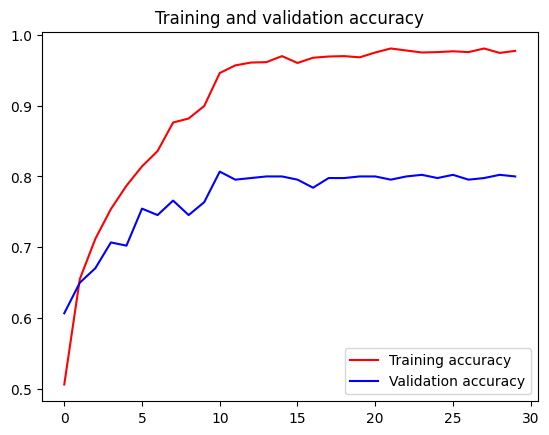

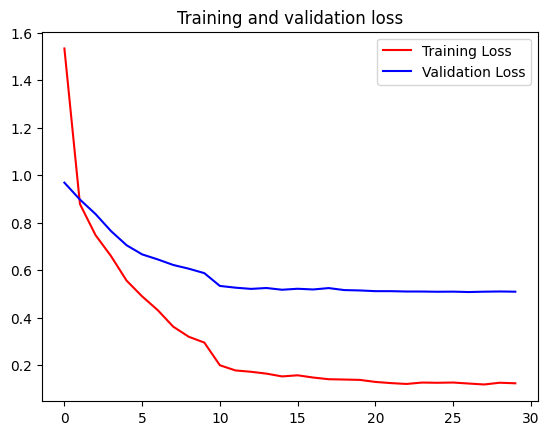

In [22]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']

val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00


In [24]:
pip install --upgrade tensorflow-addons


In [25]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load DenseNet121 with pre-trained weights, excluding the top classification layer
base_model2 = DenseNet121(
    input_shape=(416, 416, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the base model
for layer in base_model2.layers:
    layer.trainable = False

# Add your own classification layers on top of DenseNet121 with self-attention
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


29084464/29084464 [==============================] - 0s 0us/step


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

model_filepath = "/content/drive/My Drive2/model={epoch:02d}-{val_accuracy:.4f}.hdf5"

# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

        # Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    model='max',
    save_best_only=True,
    verbose=1
)

In [27]:
# Compile the model with the desired optimizer and loss function
optimizer = Adam(learning_rate=0.001)  # Initial learning rate
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Corrected typo here
    callbacks=[lr_scheduler, checkpoint]
)


Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 4.0672 - accuracy: 0.3415
Epoch 1: val_accuracy improved from -inf to 0.46136, saving model to /content/drive/My Drive2/model=01-0.4614.hdf5
55/55 [==============================] - 57s 739ms/step - loss: 4.0672 - accuracy: 0.3415 - val_loss: 1.6372 - val_accuracy: 0.4614 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - ETA: 0s - loss: 1.4907 - accuracy: 0.4659
Epoch 2: val_accuracy improved from 0.46136 to 0.47500, saving model to /content/drive/My Drive2/model=02-0.4750.hdf5
55/55 [==============================] - 22s 406ms/step - loss: 1.4907 - accuracy: 0.4659 - val_loss: 1.3090 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - ETA: 0s - loss: 1.3209 - accuracy: 0.4534
Epoch 3: val_accuracy did not improve from 0.47500
55/55 [==============================] - 21s 378ms/step - loss: 1.3209 - accuracy: 0.4534 - val_loss: 1.2202 - val_accuracy: 0.4659 - lr: 0.0010

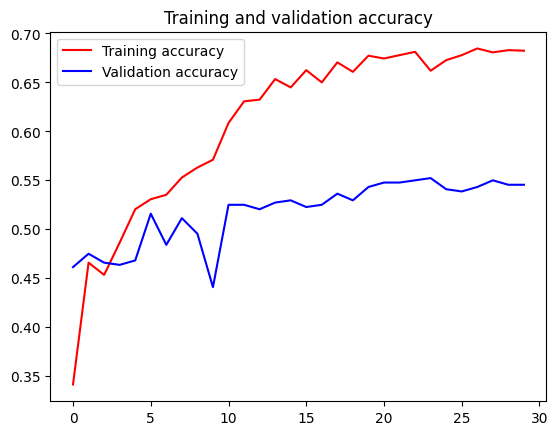

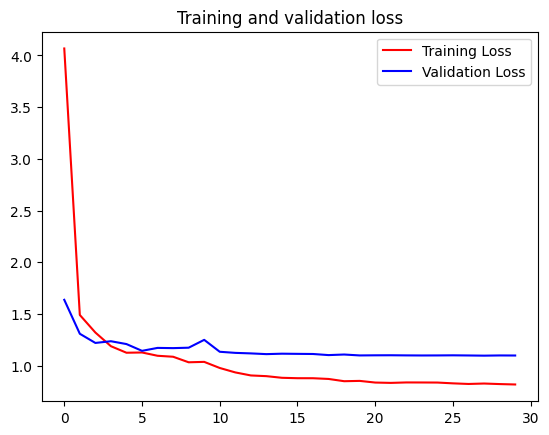

In [29]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']

val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

# Load the first model
model_1 = load_model('/content/drive/My Drive1/model=11-0.8068.hdf5')
model_1 = Model(inputs=model_1.inputs, outputs=model_1.outputs, name='name_of_model_1')

# Load the second model
model_2 = load_model('/content/drive/My Drive2/model=24-0.5523.hdf5')
model_2 = Model(inputs=model_2.inputs, outputs=model_2.outputs, name='name_of_model_2')

# List of models
models = [model_1, model_2]

# Create input layer for the ensemble model
model_input = Input(shape=(416, 416, 3))

# Get the outputs from each model
model_outputs = [model(model_input) for model in models]

# Average the outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# Print the summary of the ensemble model
ensemble_model.summary()


Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 name_of_model_1 (Functiona  (None, 4)                    2463885   ['input_3[0][0]']             
 l)                                                       2                                       
                                                                                                  
 name_of_model_2 (Functiona  (None, 4)                    7564356   ['input_3[0][0]']             
 l)                                                                                               
                                                                                           

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/My Drive1/model=12-0.8500.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/My Drive2/model=28-0.5909.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
models = [model_1, model_2]
model_input = Input(shape=(416, 416, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

model_filepath = "/content/drive/My Drive3/model={epoch:02d}-{val_accuracy:.4f}.hdf5"

# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 15:
        return 0.001
    elif epoch < 25:
        return 0.0001
    else:
        return 0.00001

        # Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    model='max',
    save_best_only=True,
    verbose=1
)

In [32]:
# Compile the model with the desired optimizer and loss function
optimizer = Adam(learning_rate=0.001)  # Initial learning rate
ensemble_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Train the model
history3 = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,  # Corrected typo here
    callbacks=[lr_scheduler, checkpoint]
)


Epoch 1/45
55/55 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7875
Epoch 1: val_accuracy improved from -inf to 0.68182, saving model to /content/drive/My Drive3/model=01-0.6818.hdf5
55/55 [==============================] - 60s 872ms/step - loss: 0.5555 - accuracy: 0.7875 - val_loss: 0.7955 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 2/45
55/55 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.7739
Epoch 2: val_accuracy improved from 0.68182 to 0.70455, saving model to /content/drive/My Drive3/model=02-0.7045.hdf5
55/55 [==============================] - 43s 779ms/step - loss: 0.5005 - accuracy: 0.7739 - val_loss: 0.7766 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 3/45
55/55 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7892
Epoch 3: val_accuracy did not improve from 0.70455
55/55 [==============================] - 42s 763ms/step - loss: 0.4845 - accuracy: 0.7892 - val_loss: 0.8046 - val_accuracy: 0.6727 - lr: 0.0010

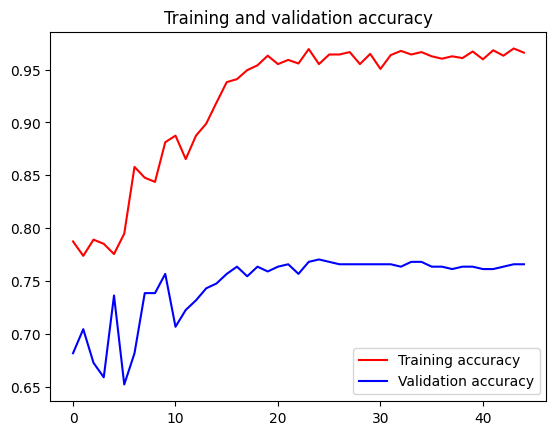

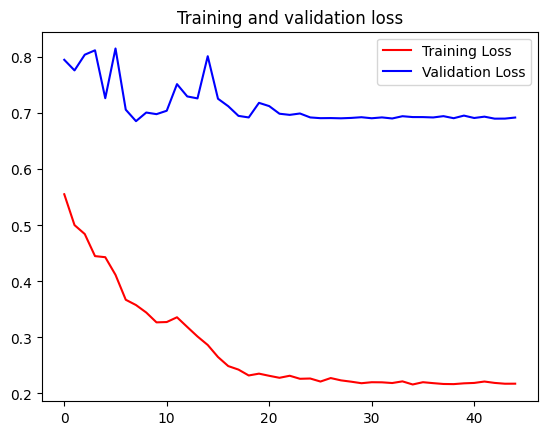

In [34]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']

val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [35]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)
test_label = np.concatenate([y for x, y in val_ds], axis=0)
print(test_label.shape)

(1760,)
(440,)


<ipython-input-36-e56bb698ddf7>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix
[[164   6  10   4]
 [ 27  48   4   7]
 [ 10   4 100   3]
 [  9   6  13  25]]
Classification Report
                                 precision    recall  f1-score   support

  Complete endodontic treatment       0.78      0.89      0.83       184
Incomplete endodontic treatment       0.75      0.56      0.64        86
        No endodontic treatment       0.79      0.85      0.82       117
       Total endodontic failure       0.64      0.47      0.54        53

                       accuracy                           0.77       440
                      macro avg       0.74      0.69      0.71       440
                   weighted avg       0.76      0.77      0.76       440



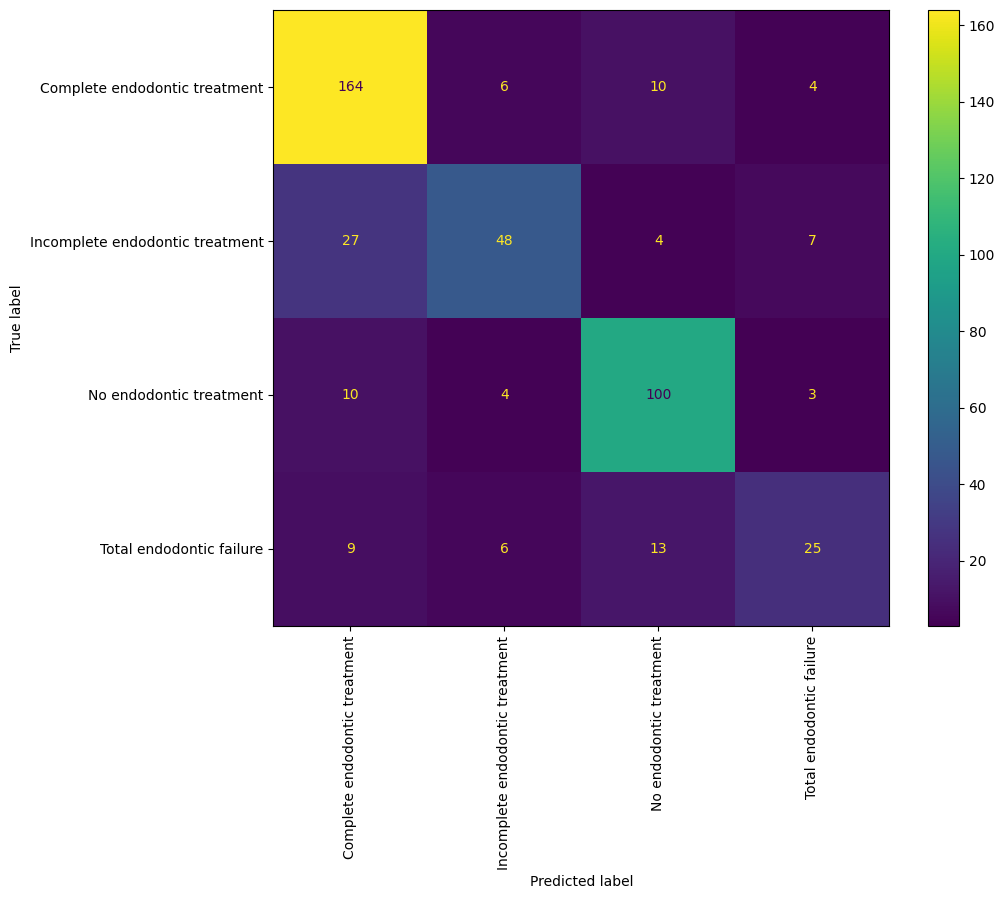

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions using the ensemble model
Y_pred = ensemble_model.predict_generator(val_ds, 1600)

# Extract predicted labels by taking argmax along axis 1
y_pred = np.argmax(Y_pred, axis=1)

# Print Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(test_label, y_pred)
print(cm)

# Print Classification Report
target_names = ['Complete endodontic treatment', 'Incomplete endodontic treatment', 'No endodontic treatment', 'Total endodontic failure']
print('Classification Report')
print(classification_report(test_label, y_pred, target_names=target_names))

# Plot Confusion Matrix with smaller font size for x-axis labels
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=plt.gca(), xticks_rotation='vertical')
plt.xticks(fontsize=10)  # Set font size for x-axis labels
plt.yticks(fontsize=10)  # Set font size for y-axis labels
plt.show()


In [38]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, Average
import tensorflow as tf

# Load the models
model_1 = load_model('/content/drive/My Drive1/model=11-0.8068.hdf5')
model_1 = Model(inputs=model_1.inputs, outputs=model_1.outputs, name='name_of_model_1')

model_2 = load_model('/content/drive/My Drive2/model=24-0.5523.hdf5')
model_2 = Model(inputs=model_2.inputs, outputs=model_2.outputs, name='name_of_model_2')

# List of models
models = [model_1, model_2]

# Create input layer for the ensemble model
model_input = Input(shape=(416, 416, 3))

# Get the outputs from each model and ensure they are probability distributions
model_outputs = [model(model_input) for model in models]

# Average the outputs (soft voting)
ensemble_output = Average()(model_outputs)

# Create the ensemble model
Vensemble = Model(inputs=model_input, outputs=ensemble_output, name='Vensemble')

# Print the summary of the ensemble model
Vensemble.summary()


Model: "Vensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 name_of_model_1 (Functiona  (None, 4)                    2463885   ['input_4[0][0]']             
 l)                                                       2                                       
                                                                                                  
 name_of_model_2 (Functiona  (None, 4)                    7564356   ['input_4[0][0]']             
 l)                                                                                               
                                                                                          

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

model_filepath = "/content/drive/My Drive4/model={epoch:02d}-{val_accuracy:.4f}.hdf5"

# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 15:
        return 0.001
    elif epoch < 25:
        return 0.0001
    else:
        return 0.00001

        # Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    model='max',
    save_best_only=True,
    verbose=1
)

In [41]:
# Compile the model with the desired optimizer and loss function
optimizer = Adam(learning_rate=0.001)  # Initial learning rate
Vensemble.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Train the model
history4 = Vensemble.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,  # Corrected typo here
    callbacks=[lr_scheduler, checkpoint]
)


Epoch 1/45
55/55 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.8199
Epoch 1: val_accuracy improved from -inf to 0.58864, saving model to /content/drive/My Drive4/model=01-0.5886.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 58s 854ms/step - loss: 0.5483 - accuracy: 0.8199 - val_loss: 1.0300 - val_accuracy: 0.5886 - lr: 0.0010
Epoch 2/45
55/55 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7972
Epoch 2: val_accuracy improved from 0.58864 to 0.71364, saving model to /content/drive/My Drive4/model=02-0.7136.hdf5
55/55 [==============================] - 44s 796ms/step - loss: 0.4999 - accuracy: 0.7972 - val_loss: 0.7469 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 3/45
55/55 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8256
Epoch 3: val_accuracy improved from 0.71364 to 0.71818, saving model to /content/drive/My Drive4/model=03-0.7182.hdf5
55/55 [==============================] - 44s 797ms/step - loss: 0.4364 - accuracy: 0.8256 - val_loss: 0.7720 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 4/45
55/55 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8239
Epoch 4: val_accuracy did not improve from 0.71

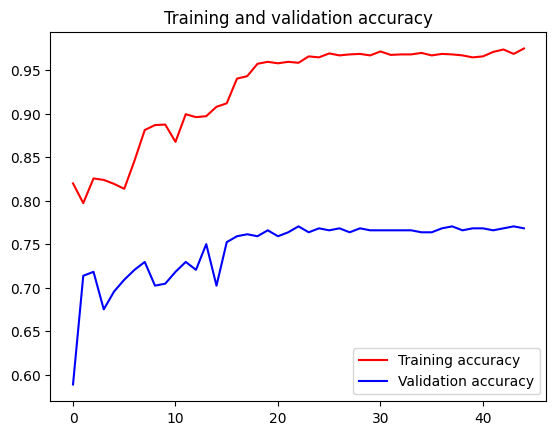

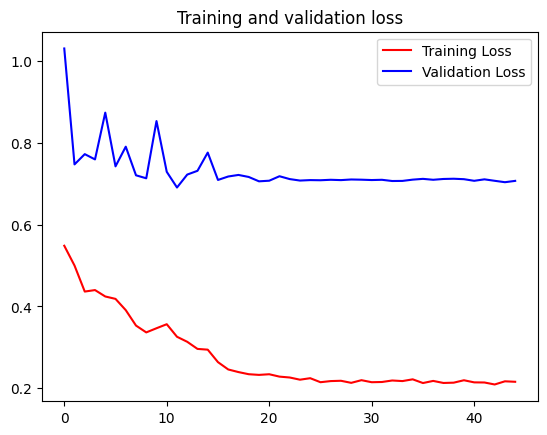

In [43]:
import matplotlib.pyplot as plt
acc = history4.history['accuracy']

val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<ipython-input-44-8cbb28d65d37>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = Vensemble.predict_generator(val_ds, 1600)


Confusion Matrix
[[164   6   9   5]
 [ 30  43   6   7]
 [  9   2 103   3]
 [  9   6  10  28]]
Classification Report
                                 precision    recall  f1-score   support

  Complete endodontic treatment       0.77      0.89      0.83       184
Incomplete endodontic treatment       0.75      0.50      0.60        86
        No endodontic treatment       0.80      0.88      0.84       117
       Total endodontic failure       0.65      0.53      0.58        53

                       accuracy                           0.77       440
                      macro avg       0.75      0.70      0.71       440
                   weighted avg       0.76      0.77      0.76       440



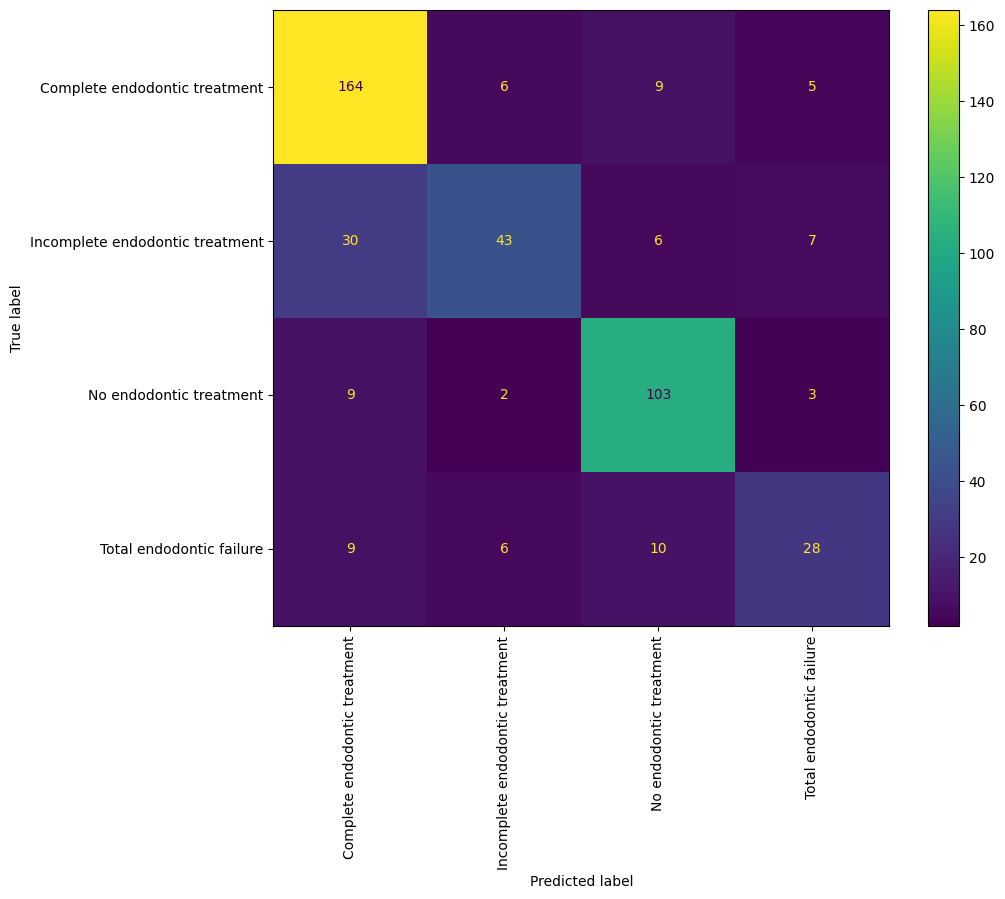

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions using the ensemble model
Y_pred = Vensemble.predict_generator(val_ds, 1600)

# Extract predicted labels by taking argmax along axis 1
y_pred = np.argmax(Y_pred, axis=1)

# Print Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(test_label, y_pred)
print(cm)

# Print Classification Report
target_names = ['Complete endodontic treatment', 'Incomplete endodontic treatment', 'No endodontic treatment', 'Total endodontic failure']
print('Classification Report')
print(classification_report(test_label, y_pred, target_names=target_names))

# Plot Confusion Matrix with smaller font size for x-axis labels
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=plt.gca(), xticks_rotation='vertical')
plt.xticks(fontsize=10)  # Set font size for x-axis labels
plt.yticks(fontsize=10)  # Set font size for y-axis labels
plt.show()
